In [2]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [3]:
!pip install diffusers transformers accelerate pillow

In [4]:
from diffusers import DiffusionPipeline
import torch
from PIL import Image

# Load the pipeline
pipe = DiffusionPipeline.from_pretrained("timbrooks/instruct-pix2pix")

# Move the model to GPU (CUDA)
pipe.to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionInstructPix2PixPipeline {
  "_class_name": "StableDiffusionInstructPix2PixPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "timbrooks/instruct-pix2pix",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
# Load and preprocess the input image
input_image = Image.open("me.jpeg").convert("RGB").resize((512, 512))  # Resize for efficiency

# Define the text prompt
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

# Generate the edited image
edited_image = pipe(prompt=prompt, image=input_image).images[0]

# Save or display the result
edited_image.show()
edited_image.save("edited_me_cuda.jpeg")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

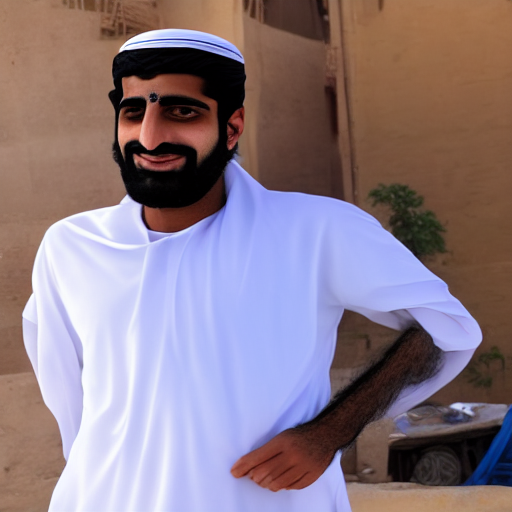

In [7]:
prompt = "what is it looks like if he is Arab"
pipe(prompt, image=input_image, num_inference_steps=20, image_guidance_scale=1).images[0]



In [8]:
# from diffusers import DiffusionPipeline
# from PIL import Image
# import torch

class InstructPix2PixRealTime:
    def __init__(self, model_name="timbrooks/instruct-pix2pix", device="cuda"):
        # Load the pipeline and set device (CPU or GPU)
        self.pipe = DiffusionPipeline.from_pretrained(model_name)
        self.pipe.to(device)
        self.device = device

    def process_image(self, image_path, prompt, output_path="output.png", steps=25):
        # Load and preprocess the image
        input_image = Image.open(image_path).convert("RGB").resize((512, 512))

        # Generate the edited image
        edited_image = self.pipe(prompt=prompt, image=input_image, num_inference_steps=steps).images[0]

        # Save the output
        edited_image.save(output_path)
        return edited_image

    def process_image_pil(self, input_image, prompt, steps=25):
        # Process a PIL image directly
        input_image = input_image.convert("RGB").resize((512, 512))
        edited_image = self.pipe(prompt=prompt, image=input_image, num_inference_steps=steps).images[0]
        return edited_image


In [9]:
from pathlib import Path

SAVE_MODEL_EVERY = 1  # Save every epoch/iteration
DCGAN_DIR = Path("./saved_models")  # Path to save models
DCGAN_DIR.mkdir(exist_ok=True)  # Ensure directory exists

GENERATOR_NAME = "InstructPix2Pix_Generator"
DISCRIMINATOR_NAME = "InstructPix2Pix_Discriminator"  # If applicable


In [10]:
def save_pipeline(pipe, save_dir, iteration):
    print(f"Saving pipeline at iteration {iteration} to {save_dir}")

    # Save scripted pipeline (TorchScript for deployment)
    scripted_pipe = torch.jit.script(pipe.unet)
    scripted_pipe.save(save_dir / f"pipeline_scripted_{iteration:04d}.pt")

    # Save state_dict for retraining or reuse
    torch.save(pipe.unet.state_dict(), save_dir / f"pipeline_state_{iteration:04d}.pt")